In [637]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [638]:
sADF=pd.read_csv(r"C:\Users\Hasib\OneDrive - University of Calgary\PIMS M2PI Workshop 2022\Novion GI\Site A - Tue Feb 15 2022 to Thu Jun 30 2022.csv")
sBDF=pd.read_csv(r"C:\Users\Hasib\OneDrive - University of Calgary\PIMS M2PI Workshop 2022\Novion GI\Site B - Tue Feb 15 2022 to Thu Jun 30 2022.csv")

In [639]:
#sADF.head()

In [640]:
#print(sADF.shape,sBDF.shape)

In [641]:
#print(sADF.columns,sBDF.columns)

In [642]:
pd.to_datetime(sADF["Timestamp"]);
pd.to_datetime(sBDF["Timestamp"]);

In [643]:
def IdentifyEvents_3(df):
    #  This method use moving STD (std_mov) (last 6 hours) for start and end of an event
    # For the start of an event use: std_mov > mean (std_mov) 
    # To detect the end of an event use: std_mov < range(std_mov)*2%
    skip=4*(5*12)    # 5 hours of no significant change in water level means start of another event
    wlc_mm=np.diff(df[" Water Level [m]"])*1000 # water level change measured in mm
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    ###### this part calculates the moving STD
    mean_mov=[wl_mm[0]]
    std_mov=[0]
    for i in range(np.size(wl_mm)):
        periods=int((6*60)/5)   #6 hours 
        if i<periods:
            mean_mov.append(np.mean(wl_mm[:i+1]))
            std_mov.append(np.std(wl_mm[:i+1]))
        else:
            mean_mov.append(np.mean(wl_mm[i-periods:i+1]))
            std_mov.append(np.std(wl_mm[i-periods:i+1]))
    
    rng=(np.max(std_mov)-np.min(std_mov))*(3/100)     # 3% of range of std_mov
    mn=np.mean(std_mov)
    ########################################
    nre=True
    # rpc=0
    dpc=0
    start_time=[]
    end_time=[]
    start_index=[]
    end_index=[]
    duration=[]
    i=1
    while i<df.shape[0]-1:
        if std_mov[i]>=mn:
            if nre==True:
                # This is a new rainfall event
                start_time.append(df["Timestamp"][i])
                start_index.append(i)
                nre=False
                i+=1
            while std_mov[i]>rng:
                i+=1
            if np.max(std_mov[i+1:i+skip+1])<mn:
                # dry period starts from index i+1
                end_time.append(df["Timestamp"][i])
                end_index.append(i)
                nre=True
                i=i+skip
        i+=1

    return start_time,end_time,start_index,end_index,np.subtract(end_index,start_index),wl_mm

In [645]:
wl_mmA=sADF[" Water Level [m]"].to_numpy()*1000  # water level in mm
std_movA=[0]
for i in range(np.size(wl_mmA)):
    periods=int((6*60)/5)   #6 hours 
    if i<periods:
        std_movA.append(np.std(wl_mmA[:i+1]))
    else:
        std_movA.append(np.std(wl_mmA[i-periods:i+1]))
    
rngA=(np.max(std_movA)-np.min(std_movA))*(3/100)     # 3% of range of std_mov

In [646]:
start_timeA,end_timeA,start_indexA,end_indexA,rf_durationA,water_levelA=IdentifyEvents_3(sADF)
rf_eventA=pd.DataFrame({"Rainfall_start_time":start_timeA,"Rainfall_end_time":end_timeA,"Rainfall_start_index":start_indexA,"Rainfall_end_index":end_indexA,"Rainfall_duration":rf_durationA})
rf_eventA

,Rainfall_start_time,Rainfall_end_time,Rainfall_start_index,Rainfall_end_index,Rainfall_duration
0,2022-02-19 11:50:00 a.m.,2022-02-20 5:05:00 a.m.,1089,1296,207
1,2022-02-21 4:05:00 a.m.,2022-02-21 2:05:00 p.m.,1572,1692,120
2,2022-02-26 5:45:00 p.m.,2022-03-03 3:10:00 a.m.,3176,4441,1265
3,2022-03-11 9:15:00 p.m.,2022-03-16 7:25:00 a.m.,6962,8224,1262
4,2022-03-17 7:20:00 a.m.,2022-03-23 10:40:00 p.m.,8511,10423,1912
5,2022-03-26 5:25:00 a.m.,2022-03-26 4:15:00 p.m.,11080,11210,130
6,2022-03-28 4:30:00 a.m.,2022-03-28 6:15:00 p.m.,11645,11810,165
7,2022-03-29 11:40:00 p.m.,2022-03-30 8:45:00 a.m.,12163,12272,109
8,2022-04-03 5:50:00 a.m.,2022-04-04 11:55:00 a.m.,13389,13750,361
9,2022-04-08 1:45:00 a.m.,2022-04-08 9:25:00 a.m.,14780,14872,92


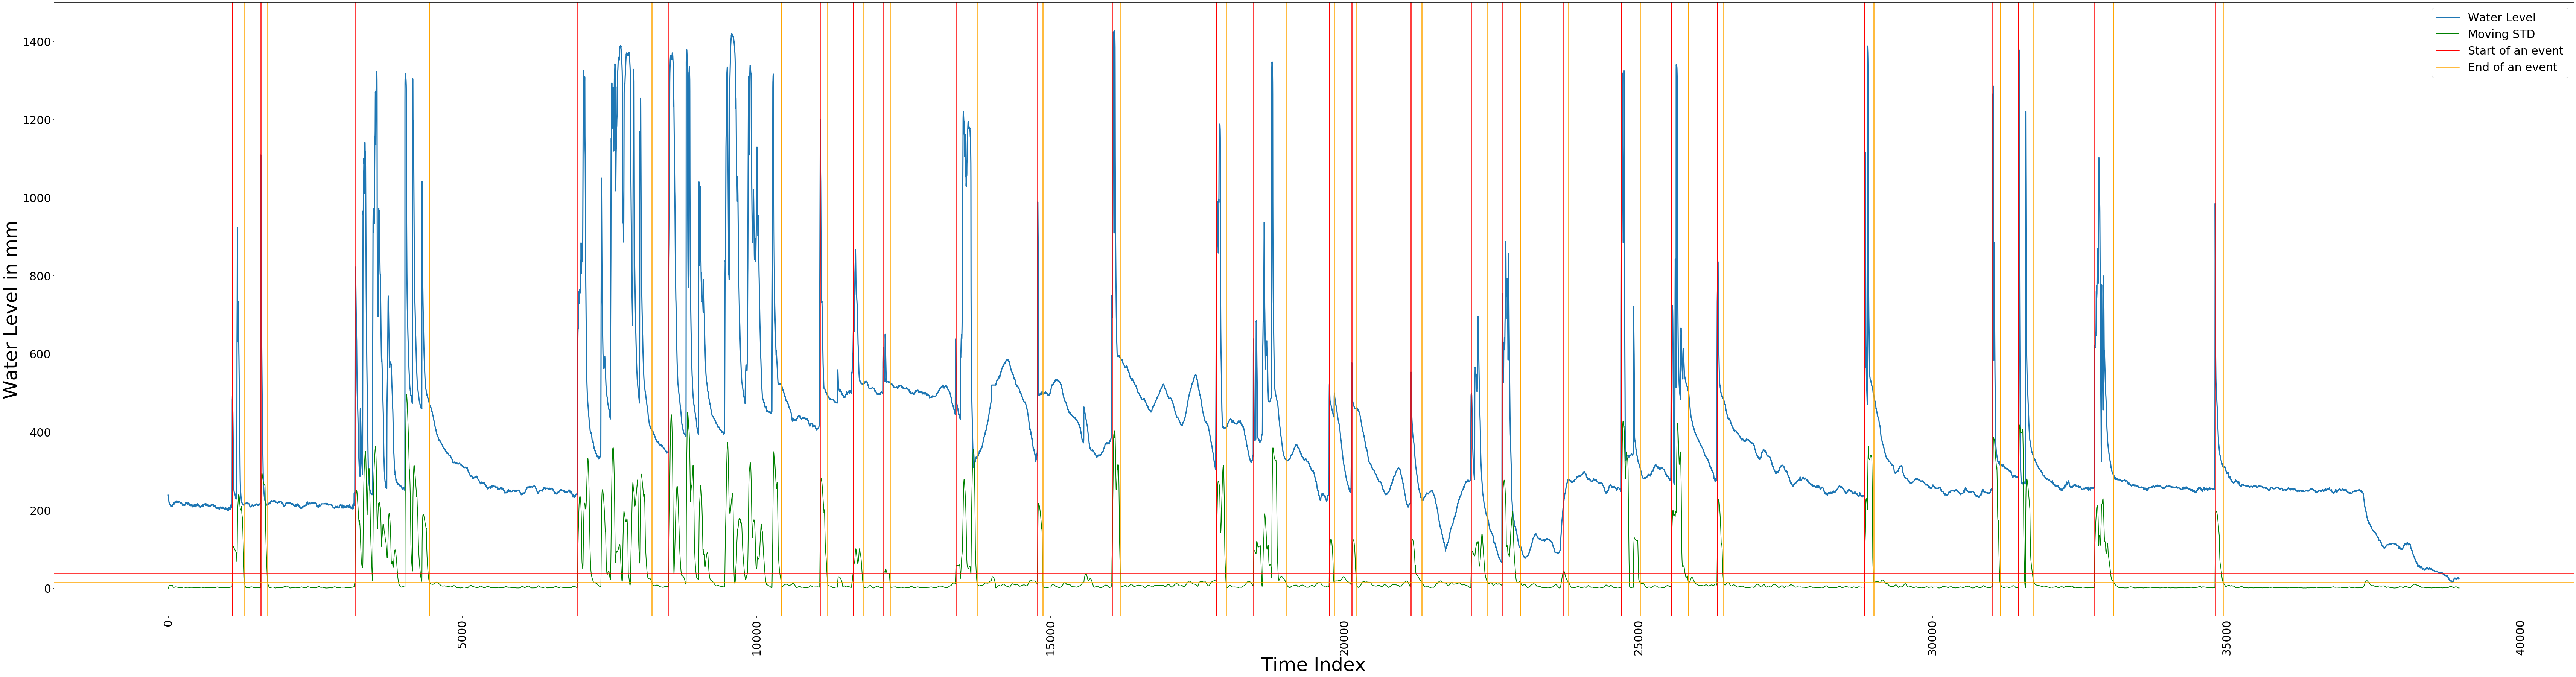

In [647]:
plt.figure(figsize=(120, 30))
wle,=plt.plot(water_levelA,label='Water Level',linewidth=3)
#plt.plot(mean_mov)
mstd,=plt.plot(std_movA,label="Moving STD",linewidth=2,color="green")
for i in start_indexA:
    st=plt.axvline(x=i, linewidth=2.5,color='r',label="Start of an event")
for i in end_indexA:
    en=plt.axvline(x=i,linewidth=2.5, color='orange',label="End of an event")
plt.axhline(y=rngA, color='orange', linestyle='-')
plt.axhline(y=np.mean(std_movA), color='red', linestyle='-')
plt.xlabel('Time Index',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',handles=[wle,mstd,st,en],fontsize=30)
plt.show()

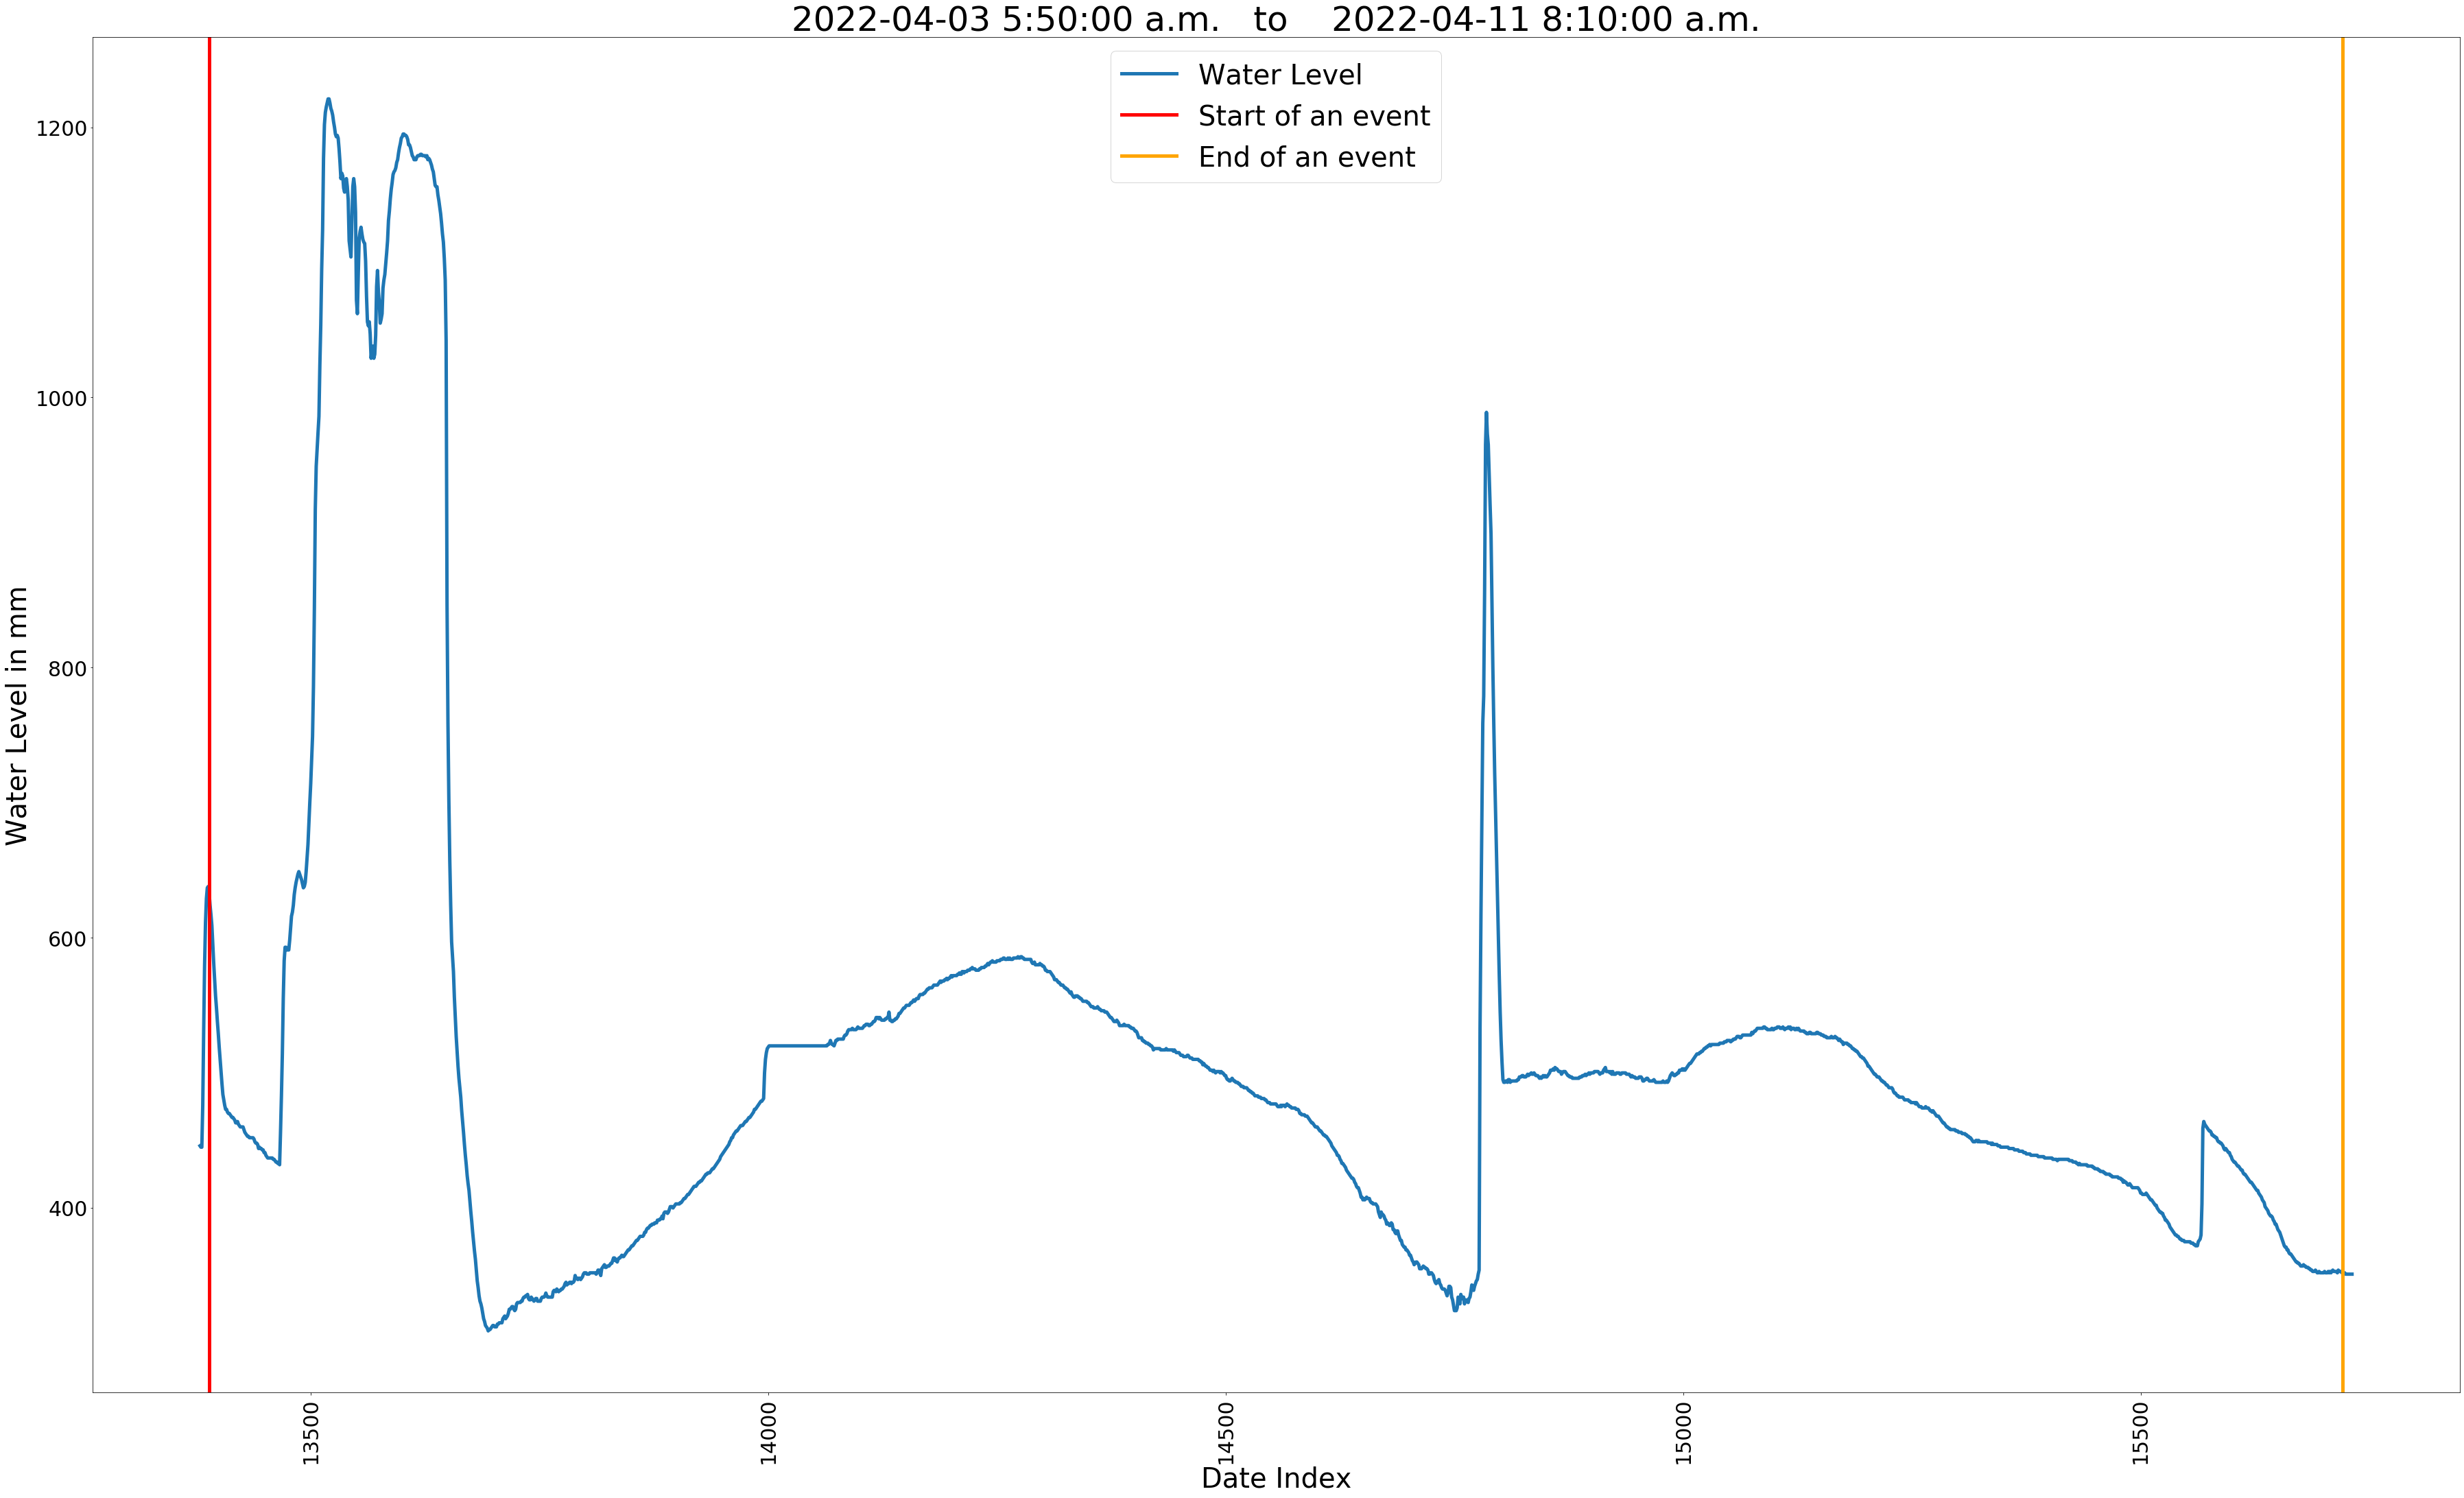

In [564]:
# Let's see a particular !Rainfall event
buffer=10
index=5
#X=Timestamp[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer+1]
X=range(start_indexA[index]-buffer,end_indexA[index]+buffer+1)
Y=wl_mm[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer+1]
plt.figure(figsize=(50, 30))
plt.plot(X,Y,linewidth=5,label="Water Level")
plt.axvline(x=start_indexA[index],linewidth=5,color='r',label="Start of an event")
plt.axvline(x=end_indexA[index],linewidth=5, color='orange',label="End of an event")
plt.title('Rainfall Event')
plt.xlabel('Date Index',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',fontsize=40)
plt.tight_layout()
plt.title(start_timeA[index]+"   to    "+end_timeA[index],fontsize=50)
plt.show()

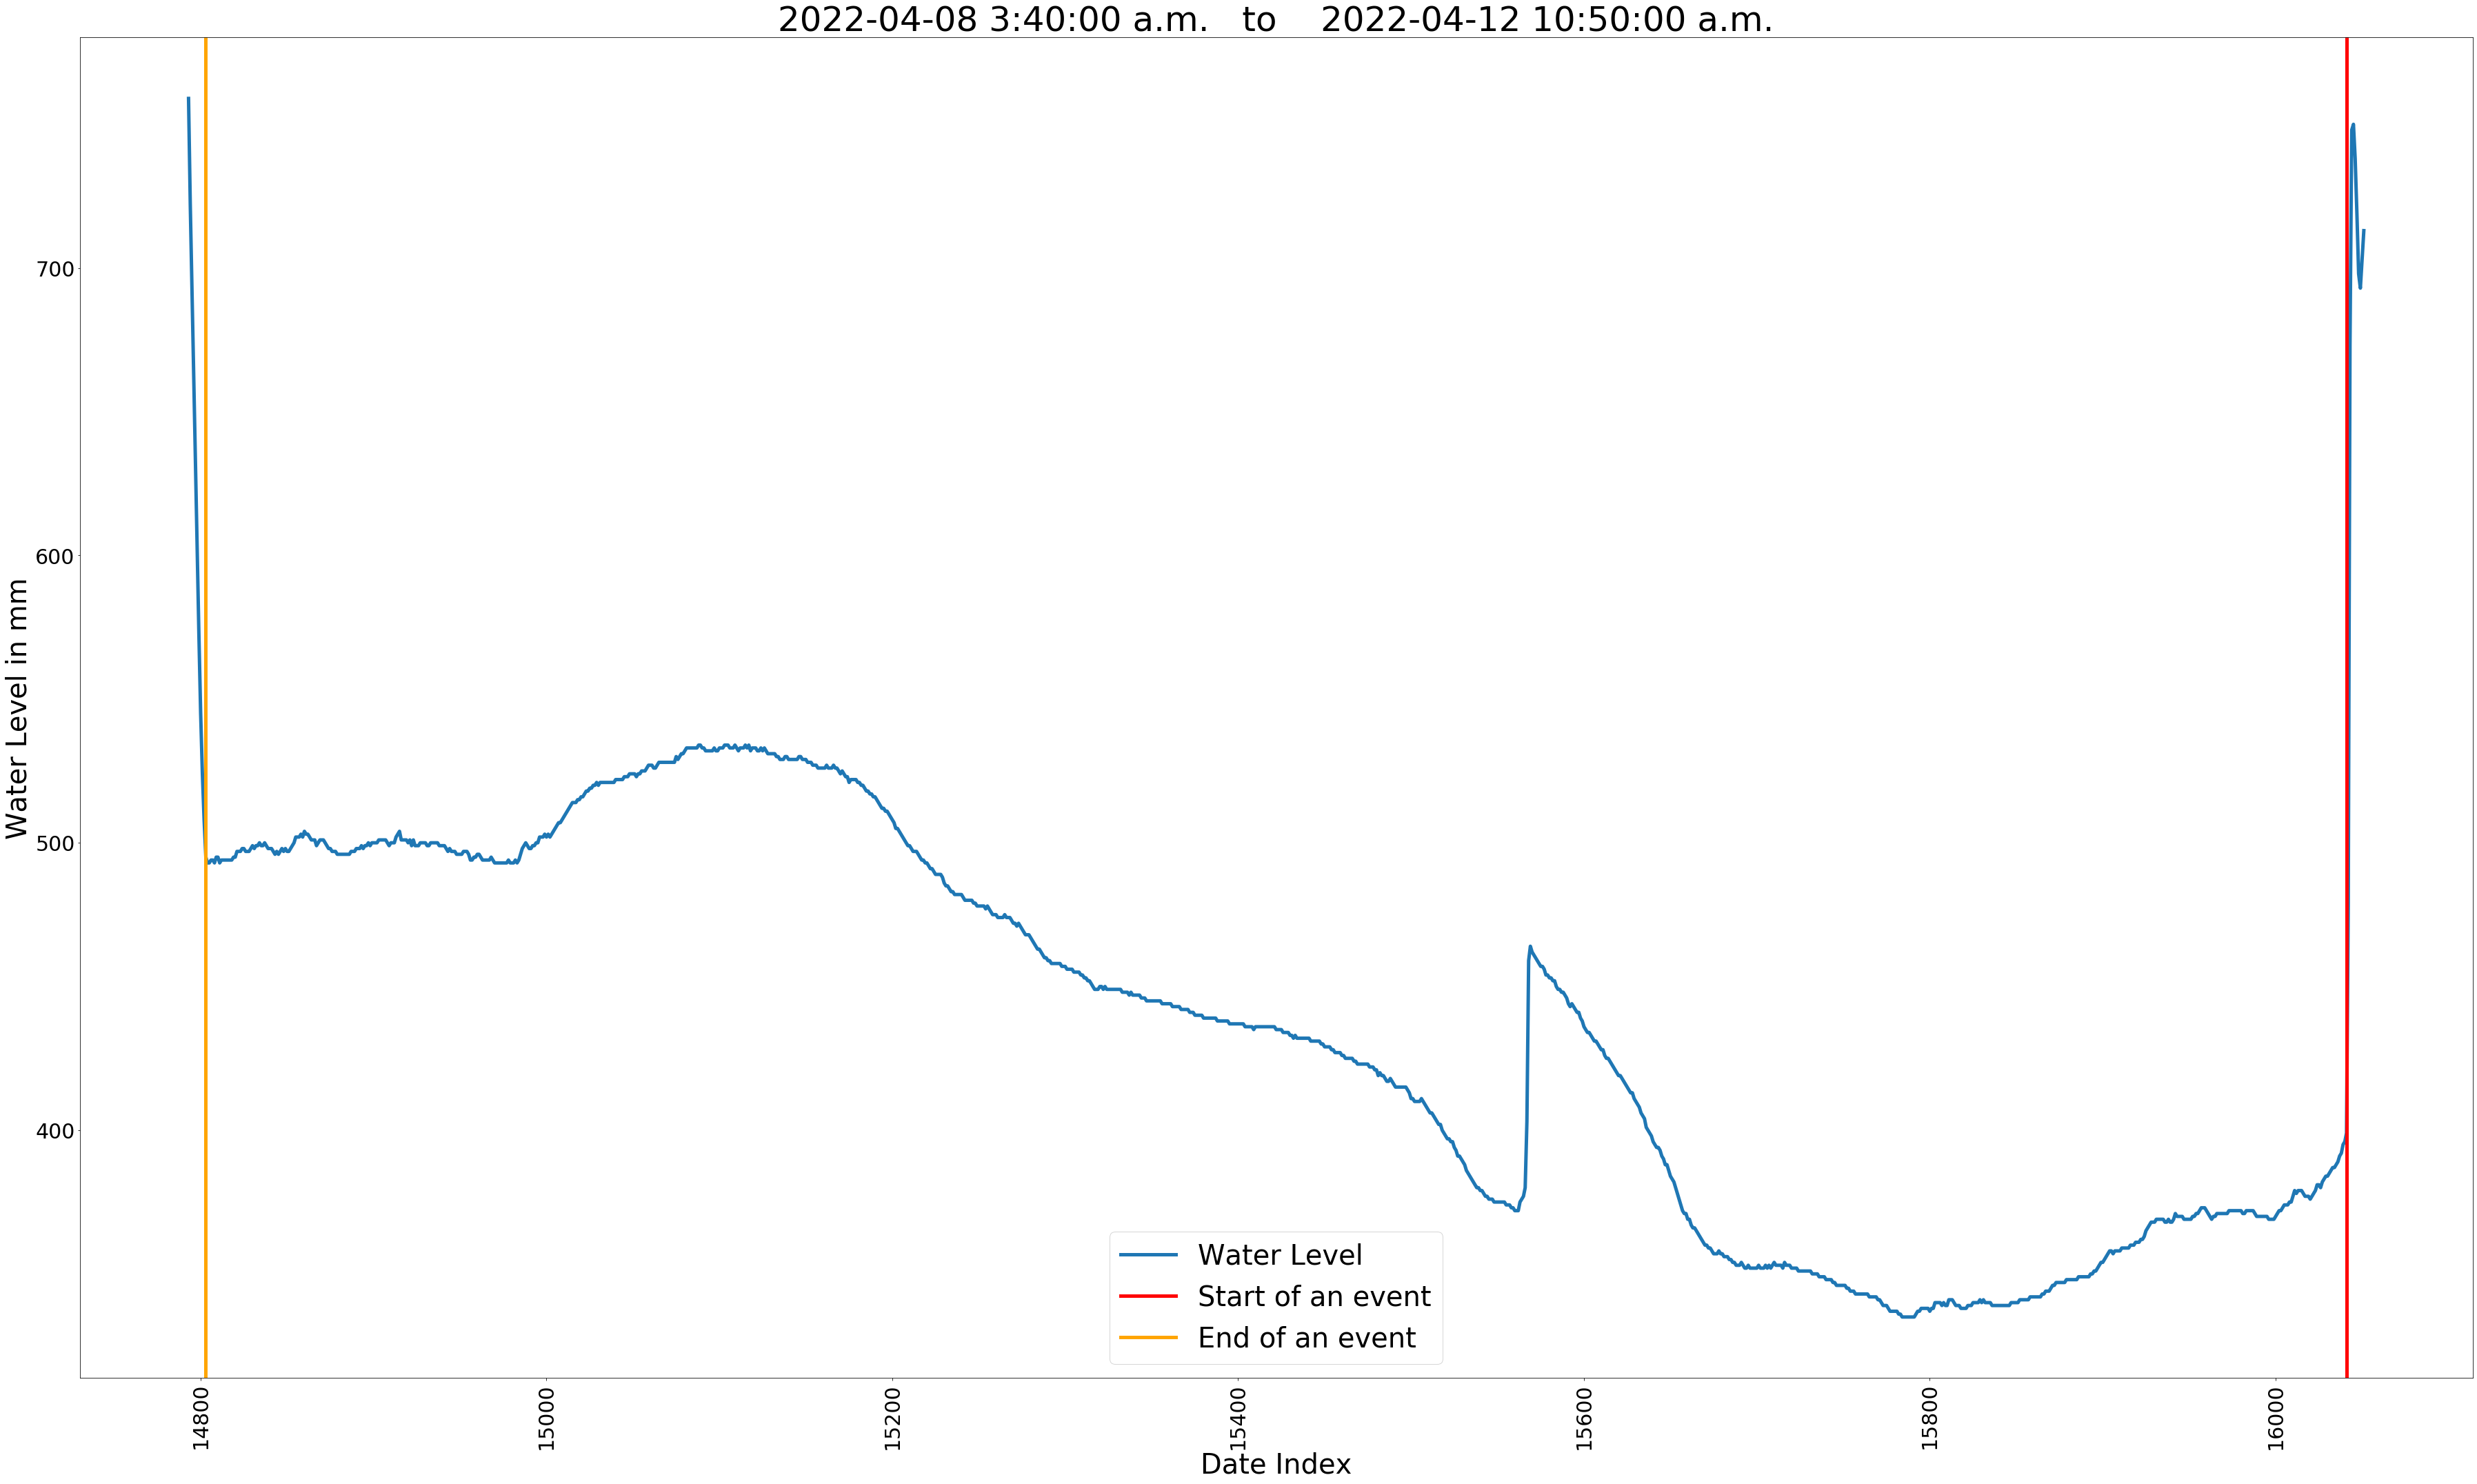

In [484]:
# Let's look at a particular No !Rainfall event
buffer=10
index=9
X=range(end_indexA[index-1]-buffer,start_indexA[index]+buffer+1)
Y=wl_mm[rf_eventA["Rainfall_end_index"][index-1]-buffer:rf_eventA["Rainfall_start_index"][index]+buffer+1]
plt.figure(figsize=(50, 30))
plt.plot(X,Y,linewidth=5,label="Water Level")
plt.axvline(x=start_indexA[index], linewidth=5,color='r',label="Start of an event")
plt.axvline(x=end_indexA[index-1],linewidth=5, color='orange',label="End of an event")
plt.title('No Rainfall Event')
plt.xlabel('Date Index',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',fontsize=40)
plt.title(end_timeA[index-1]+"   to    "+start_timeA[index],fontsize=50)
plt.tight_layout()
plt.show()

In [649]:
wl_mmB=sBDF[" Water Level [m]"].to_numpy()*1000  # water level in mm
std_movB=[0]
for i in range(np.size(wl_mmB)):
    periods=int((6*60)/5)   #6 hours 
    if i<periods:
        std_movB.append(np.std(wl_mmB[:i+1]))
    else:
        std_movB.append(np.std(wl_mmB[i-periods:i+1]))
    
rngB=(np.max(std_movB)-np.min(std_movB))*(3/100)     # 3% of range of std_mov

In [650]:
start_timeB,end_timeB,start_indexB,end_indexB,rf_durationB,water_levelB=IdentifyEvents_3(sBDF)
rf_eventB=pd.DataFrame({"Rainfall_start_time":start_timeB,"Rainfall_end_time":end_timeB,"Rainfall_start_index":start_indexB,"Rainfall_end_index":end_indexB,"Rainfall_duration":rf_durationB})
rf_eventB

,Rainfall_start_time,Rainfall_end_time,Rainfall_start_index,Rainfall_end_index,Rainfall_duration
0,2022-02-26 7:40:00 p.m.,2022-02-28 2:35:00 p.m.,3200,3715,515
1,2022-03-02 4:20:00 a.m.,2022-03-02 12:40:00 p.m.,4168,4268,100
2,2022-03-06 6:20:00 p.m.,2022-03-07 7:45:00 p.m.,5488,5793,305
3,2022-03-12 4:15:00 a.m.,2022-03-15 2:50:00 p.m.,7047,8026,979
4,2022-03-17 9:00:00 a.m.,2022-03-18 12:45:00 a.m.,8532,8721,189
5,2022-03-19 4:20:00 a.m.,2022-03-19 11:55:00 a.m.,9052,9143,91
6,2022-03-20 6:25:00 p.m.,2022-03-23 8:10:00 p.m.,9509,10394,885
7,2022-03-26 6:30:00 a.m.,2022-03-26 1:40:00 p.m.,11094,11180,86
8,2022-04-03 4:15:00 p.m.,2022-04-04 11:50:00 a.m.,13515,13750,235
9,2022-04-08 3:40:00 a.m.,2022-04-08 8:10:00 a.m.,14804,14858,54


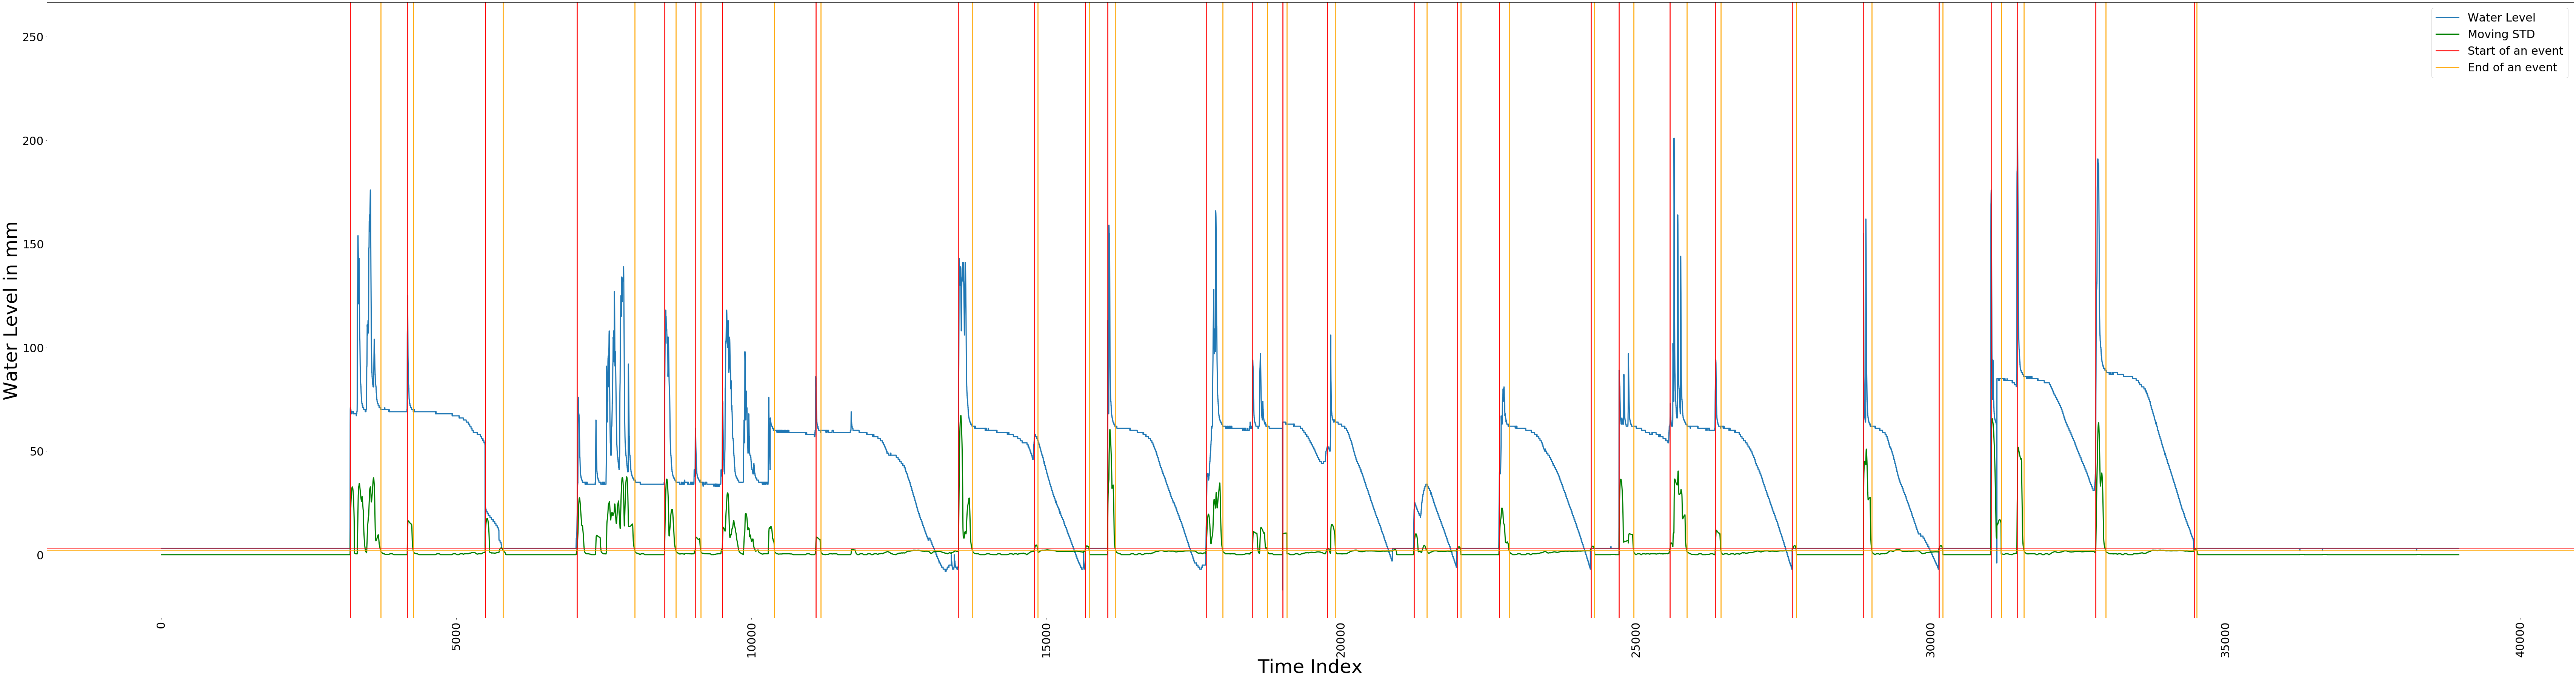

In [635]:
plt.figure(figsize=(120, 30))
wle,=plt.plot(water_levelB,label='Water Level',linewidth=3)
mstd,=plt.plot(std_mov,label="Moving STD",linewidth=3,color="green")
for i in start_indexB:
    st=plt.axvline(x=i, linewidth=2.5,color='r',label="Start of an event")
for i in end_indexB:
    en=plt.axvline(x=i,linewidth=2.5, color='orange',label="End of an event")
plt.axhline(y=rngB, color='orange', linestyle='-')
plt.axhline(y=np.mean(std_movB), color='red', linestyle='-')
plt.xlabel('Time Index',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',handles=[wle,mstd,st,en],fontsize=30)
plt.show()

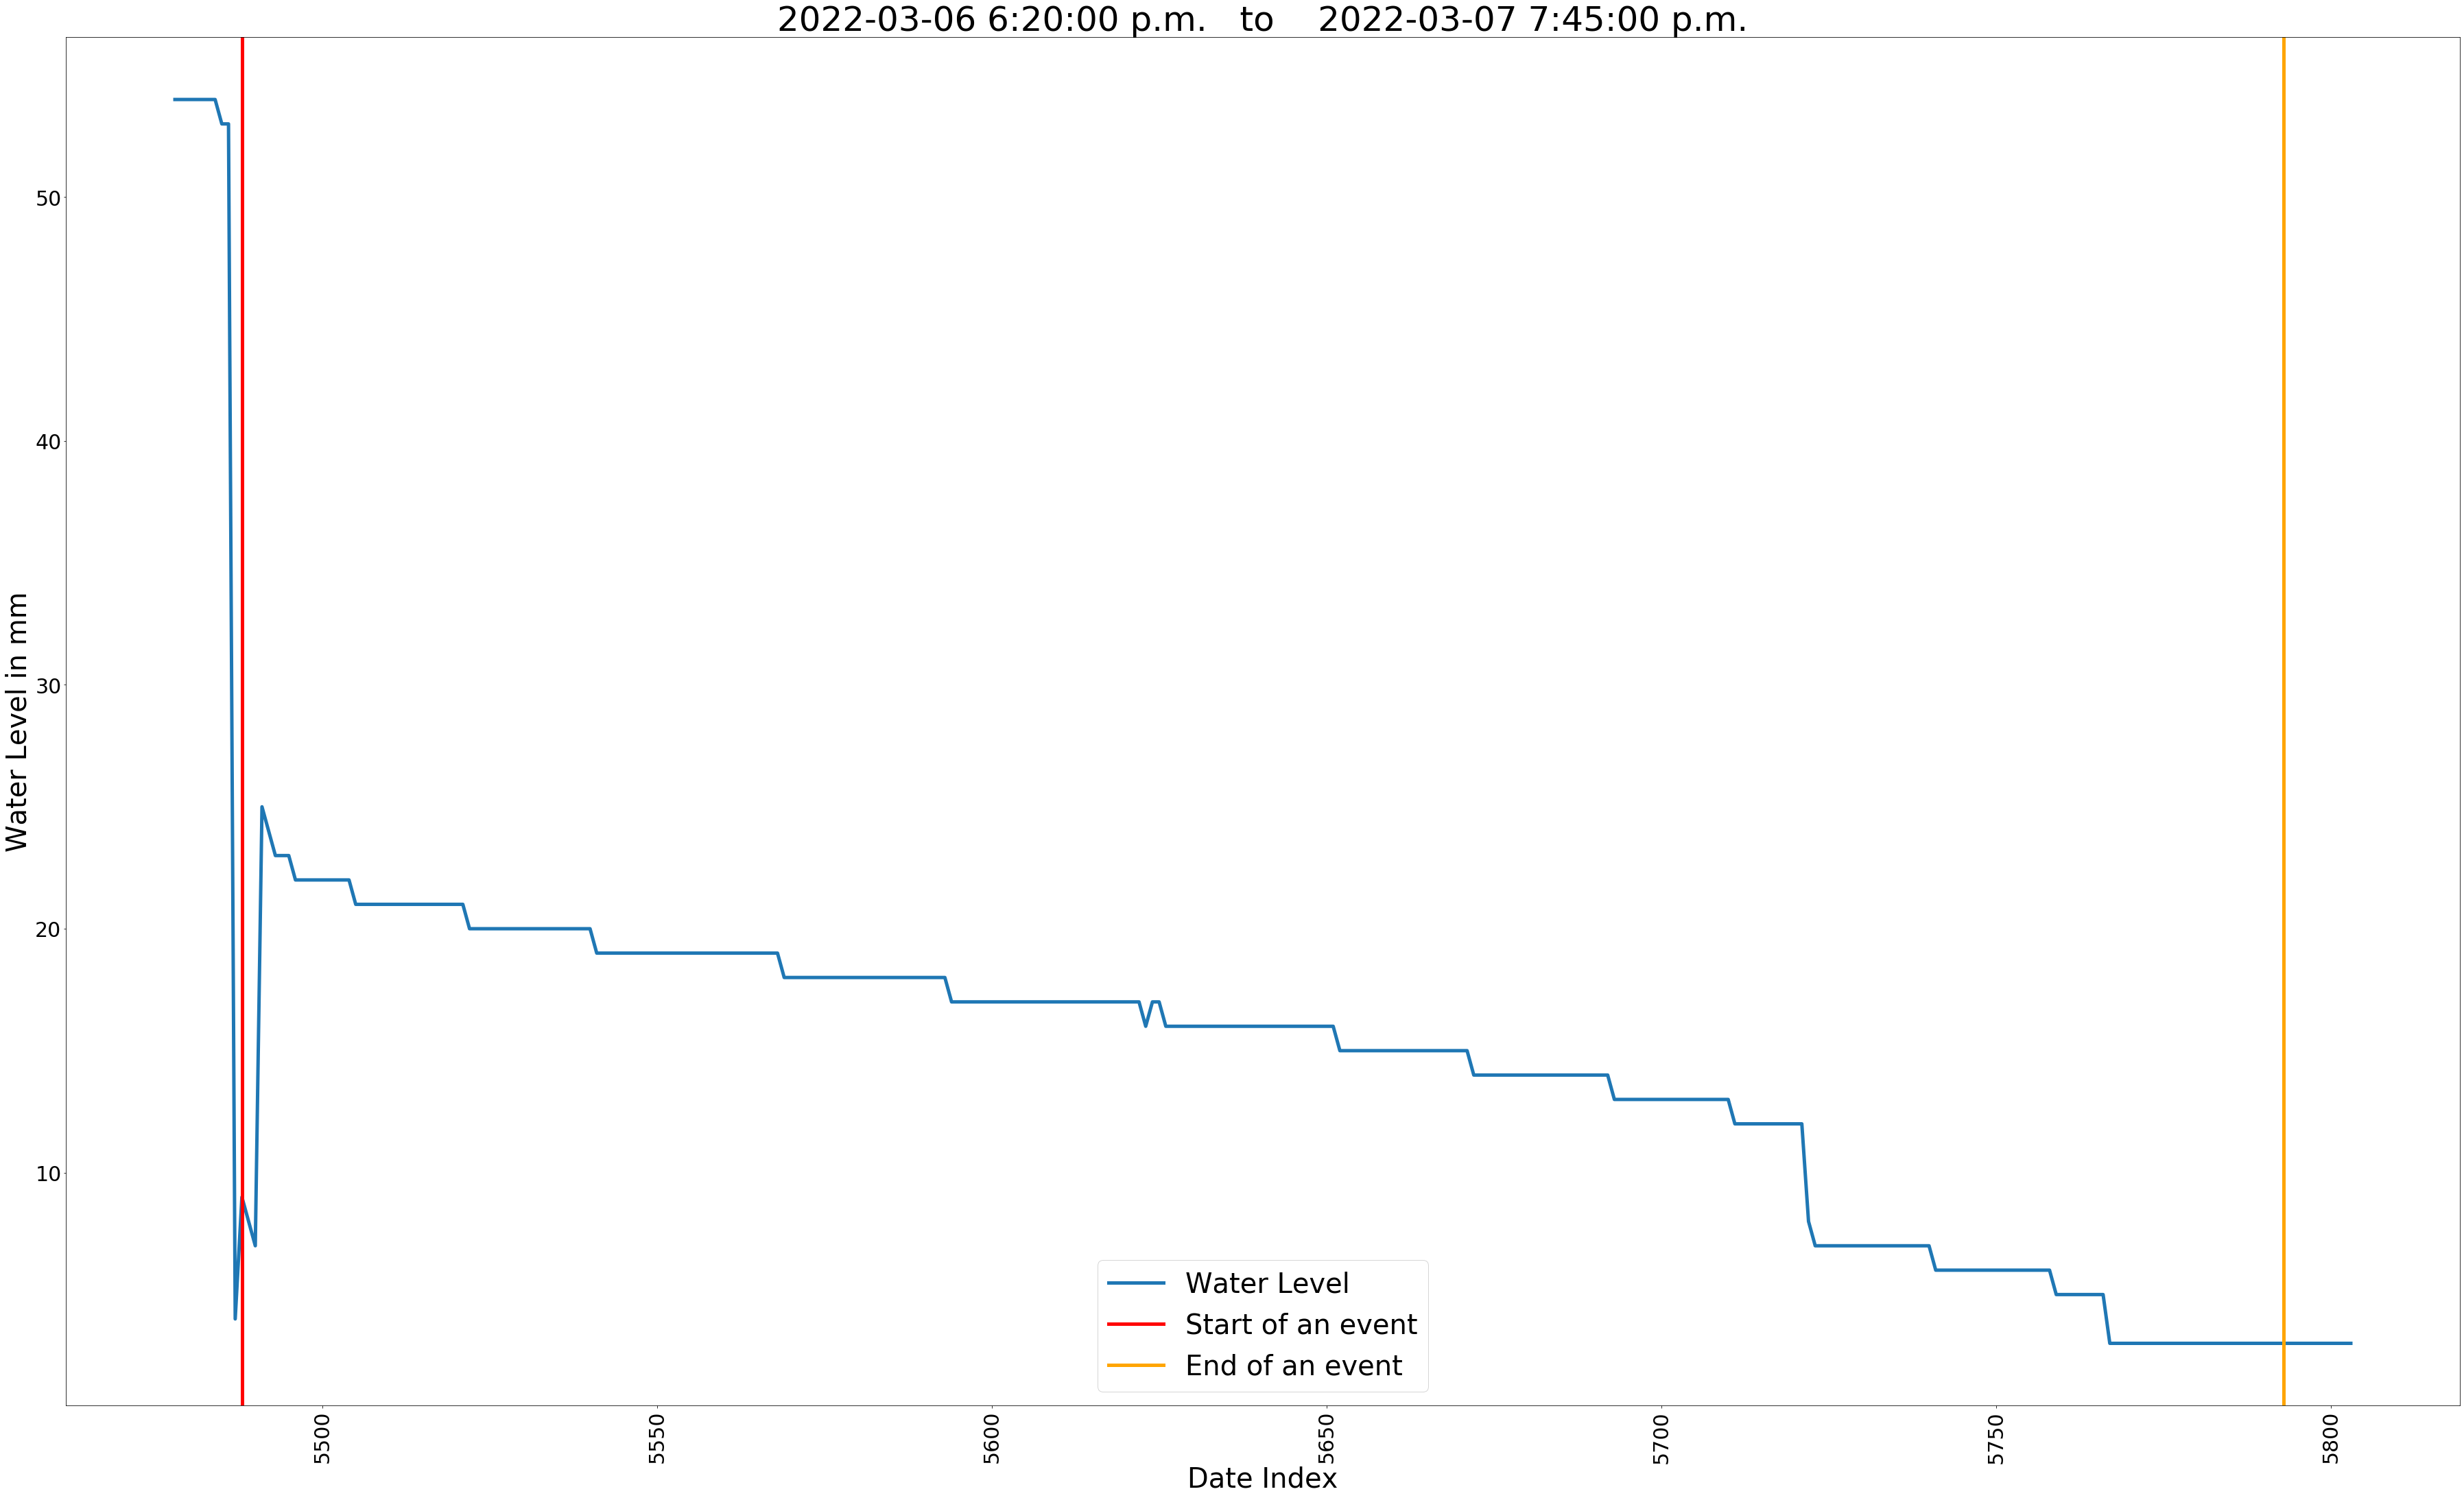

In [636]:
# Let's see a particular !Rainfall event
buffer=10
index=2
#X=Timestamp[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer+1]
X=range(start_indexB[index]-buffer,end_indexB[index]+buffer+1)
Y=wl_mm[rf_eventB["Rainfall_start_index"][index]-buffer:rf_eventB["Rainfall_end_index"][index]+buffer+1]
plt.figure(figsize=(50, 30))
plt.plot(X,Y,linewidth=5,label="Water Level")
plt.axvline(x=start_indexB[index],linewidth=5,color='r',label="Start of an event")
plt.axvline(x=end_indexB[index],linewidth=5, color='orange',label="End of an event")
plt.title('Rainfall Event')
plt.xlabel('Date Index',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',fontsize=40)
plt.tight_layout()
plt.title(start_timeB[index]+"   to    "+end_timeB[index],fontsize=50)
plt.show()

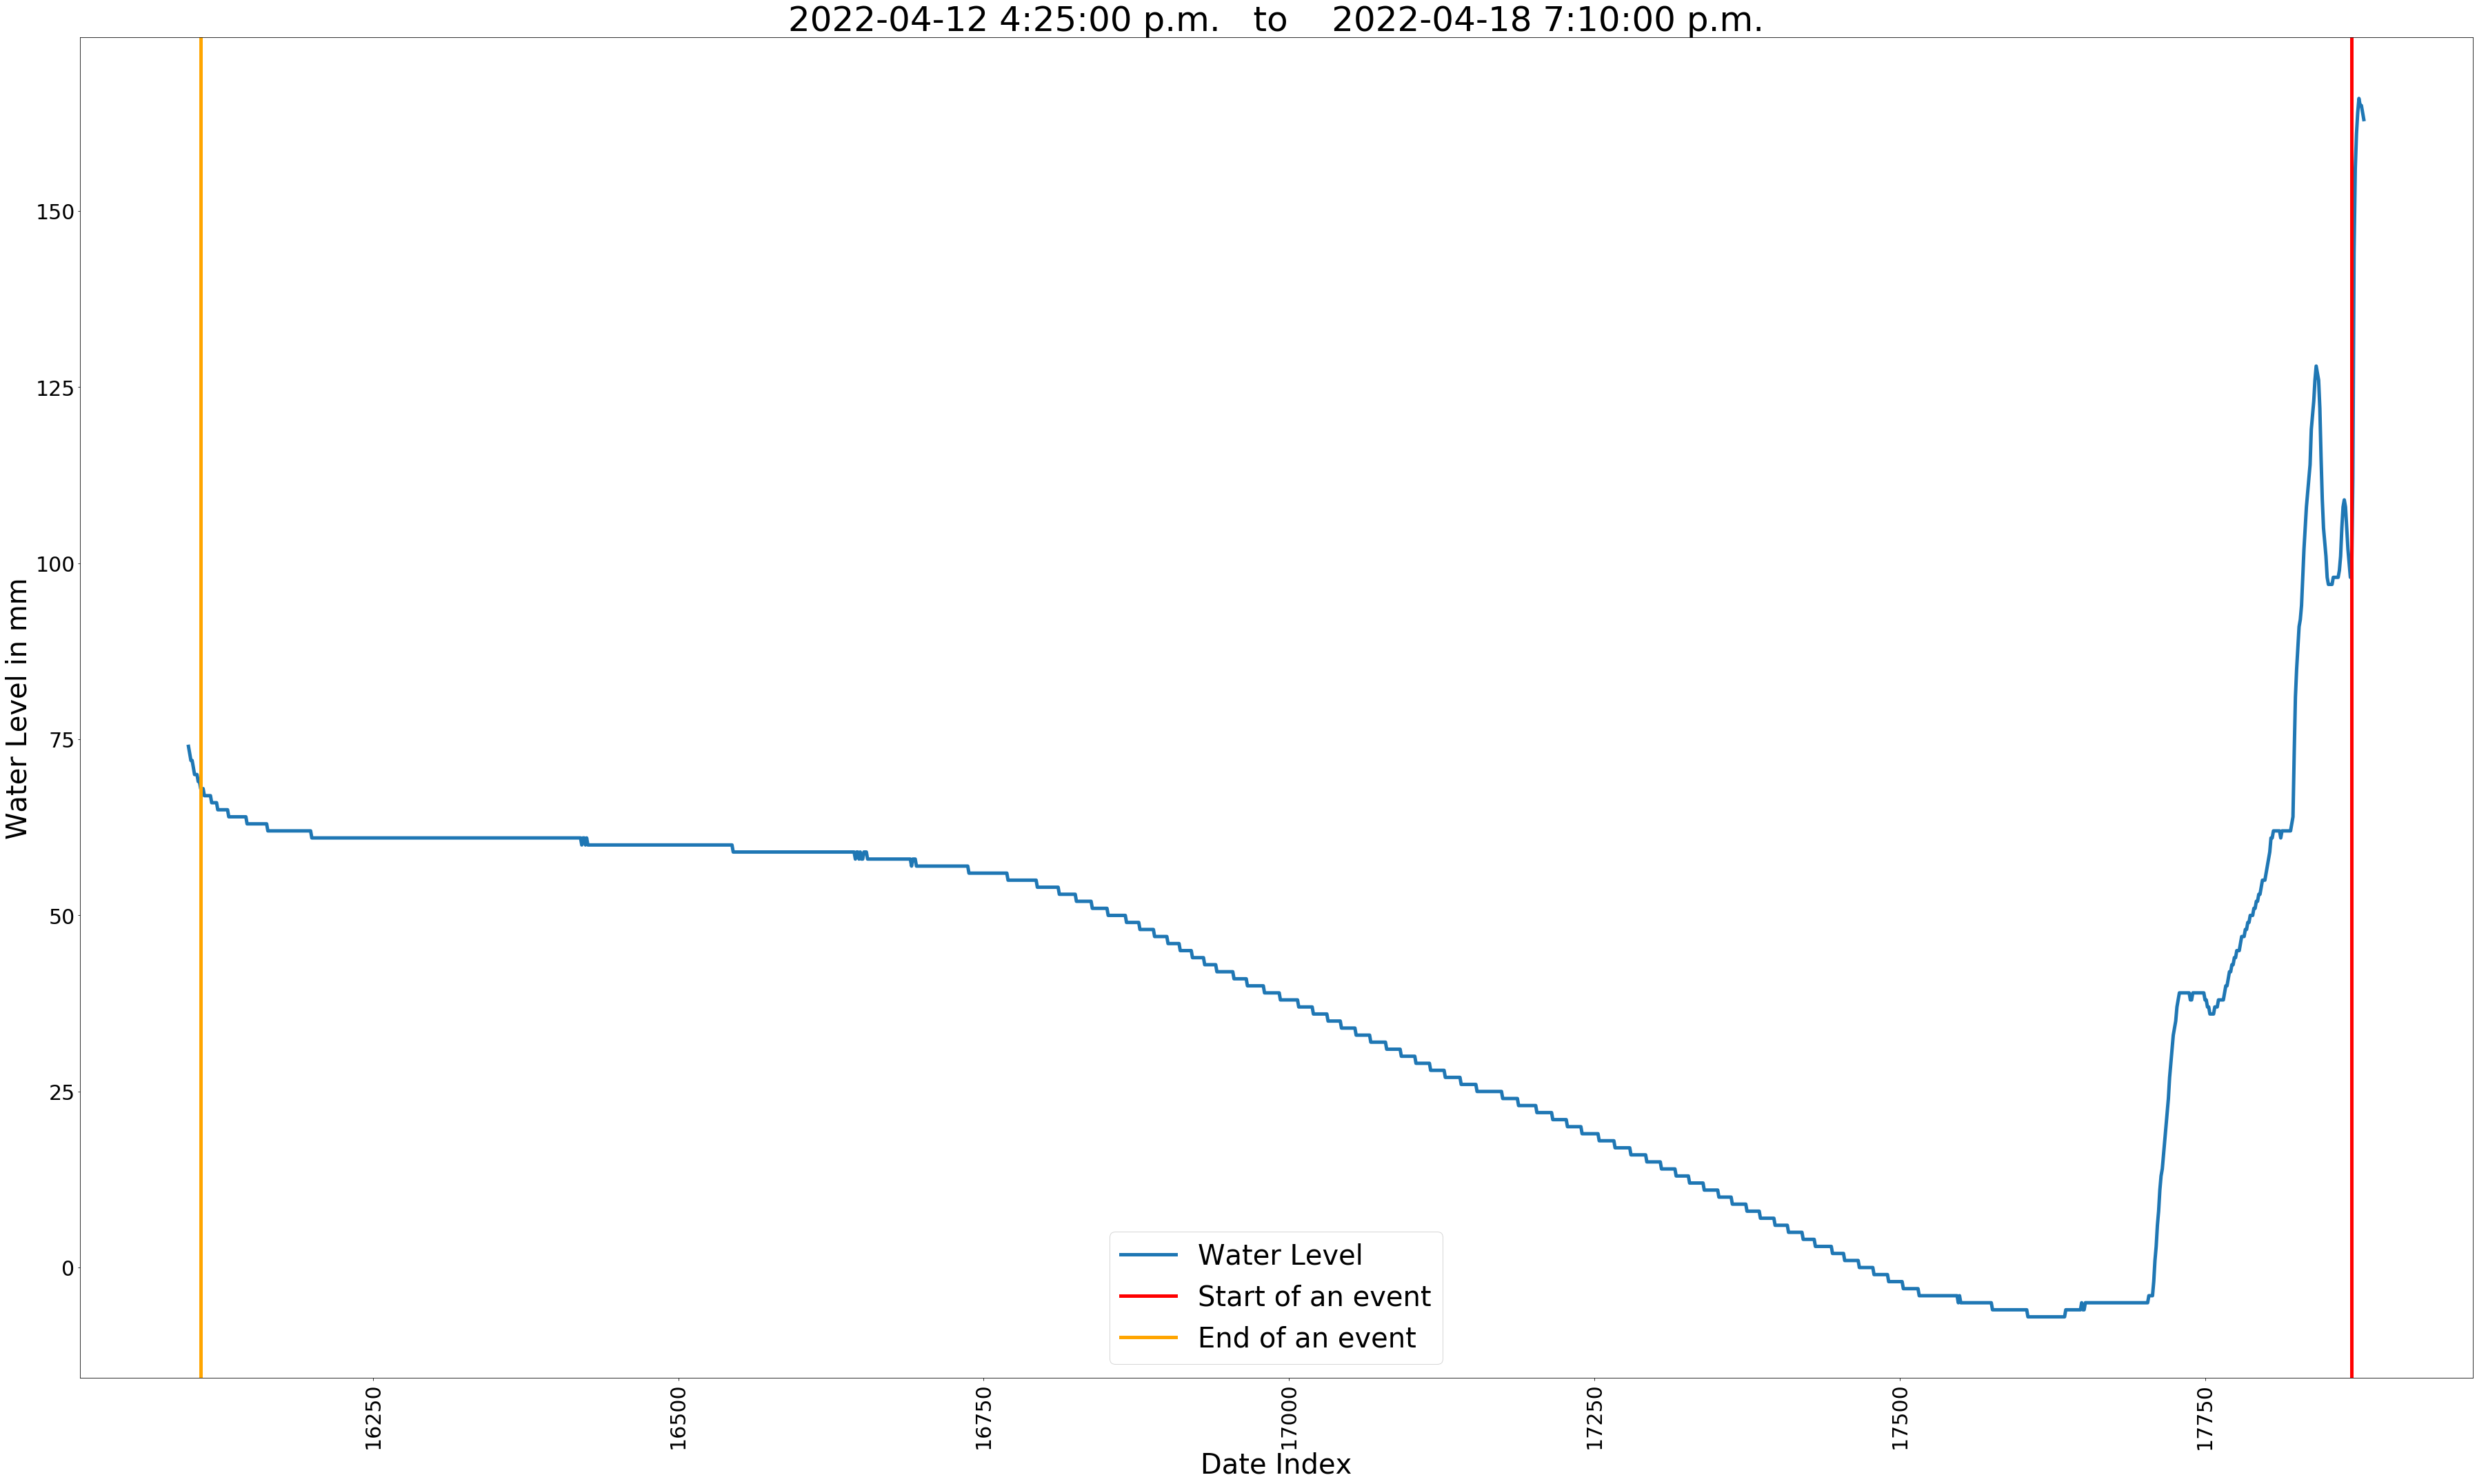

In [499]:
# Let's look at a particular No !Rainfall event
buffer=10
index=9
X=range(end_indexB[index-1]-buffer,start_indexB[index]+buffer+1)
Y=wl_mm[rf_eventB["Rainfall_end_index"][index-1]-buffer:rf_eventB["Rainfall_start_index"][index]+buffer+1]
plt.figure(figsize=(50, 30))
plt.plot(X,Y,linewidth=5,label="Water Level")
plt.axvline(x=start_indexB[index], linewidth=5,color='r',label="Start of an event")
plt.axvline(x=end_indexB[index-1],linewidth=5, color='orange',label="End of an event")
plt.title('No Rainfall Event')
plt.xlabel('Date Index',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',fontsize=40)
plt.title(end_timeB[index-1]+"   to    "+start_timeB[index],fontsize=50)
plt.tight_layout()
plt.show()